In [1]:
import os
import pandas as pd 
from dotenv import load_dotenv
from openai import AzureOpenAI
import numpy as np
import matplotlib.pyplot as plt

Loading the actual dataset of patents 

In [2]:
df = pd.read_csv("data/intern_1_nestle_patents.csv")
print(df.shape)
print(df.columns)
df.head()
df.isna().sum().sort_values(ascending=False)  # % missing per col

(1000, 8)
Index(['publication_number', 'title', 'abstract', 'claims',
       'ipc_classification', 'publication_date', 'assignee', 'legal_status'],
      dtype='object')


claims                65
abstract              63
ipc_classification     1
publication_number     0
title                  0
publication_date       0
assignee               0
legal_status           0
dtype: int64

Duplicates handling 

In [3]:
#Collect the unique companies that onw the patents 
unique_texts = (df["assignee"].dropna().astype(str).unique())

Normalise the raw assignee name

In [4]:
import unicodedata
import re

def normalize_assignee(name: str) -> str:
    if not isinstance(name, str):
        return name
    
    # 1) Strip leading/trailing whitespace
    s = name.strip()
    
    # 2) Unicode normalisation (handles weird forms consistently)
    s = unicodedata.normalize("NFKC", s)
    
    # 3) Uppercase for case-insensitive comparison
    s = s.upper()
    
    # 4) Remove accents (é → e, á → a, etc.) but keep non-Latin scripts
    s = "".join(
        ch for ch in unicodedata.normalize("NFD", s)
        if unicodedata.category(ch) != "Mn"   # drop combining marks
    )
    
    # 5) Replace common punctuation with spaces
    s = re.sub(r"[.,;:·]", " ", s)
    
    # 6) Collapse multiple spaces
    s = re.sub(r"\s+", " ", s).strip()
    
    # 7) Standardise 'S.A.' / 'S A' / 'S.A' → 'SA'
    #    (do it on word boundaries so we don't touch random 'SA' inside words)
    s = re.sub(r"\bS\s*A\b", "SA", s)
    
    # 8) Final tidy: collapse spaces again
    s = re.sub(r"\s+", " ", s).strip()
    
    return s


Map to a corporate group (Nestlé vs others)

In [5]:
def map_assignee_group(raw: str, norm: str) -> str:
    # Safety for non-strings
    if not isinstance(raw, str):
        return raw
    
    # Convenience: uppercased raw
    raw_up = raw.upper()
    
    # ---- NESTLE detection ----
    # Latin: NESTLE
    if isinstance(norm, str) and "NESTLE" in norm:
        return "NESTLE"
    
    # Cyrillic: НЕСТЛЕ
    if "НЕСТЛЕ" in raw_up:
        return "NESTLE"
    
    # Chinese: 雀巢
    if "雀巢" in raw:
        return "NESTLE"
    
    # Japanese: ネスレ
    if "ネスレ" in raw:
        return "NESTLE"
    
    # Korean: 네슬레
    if "네슬레" in raw:
        return "NESTLE"
    
    # ---- Special case: Baylor College of Medicine (Japanese) ----
    if "ベイラー カレッジ オブ メディスン" in raw:
        return "BAYLOR COLLEGE OF MEDICINE"
    
    # Default: keep normalised name as group label
    return norm if isinstance(norm, str) else raw


In [6]:
# 1. Create the normalised column
df["assignee_norm"] = df["assignee"].apply(normalize_assignee)

# 2. Create the group column
df["assignee_group"] = df.apply(
    lambda row: map_assignee_group(row["assignee"], row["assignee_norm"]),
    axis=1,
)


Changing the format of the date and time and normalisation of the patent status 

In [7]:
# publication_date looks like 20250529 → parse as YYYYMMDD
df["publication_date"] = pd.to_datetime(
    df["publication_date"].astype(str),
format="%Y%m%d", yearfirst= True

)

df["pub_year"] = df["publication_date"].dt.year

# legal_status looks like "['Pending']" → clean to simple strings
df["legal_status_clean"] = (
    df["legal_status"]
    .astype(str)
    .str.strip("[]'\"")      # remove brackets and quotes
    .str.lower()             # 'pending', 'active', 'pct designated period'
)


Check for the uniqueness of the companies 

In [8]:
#Collect the unique companies that own the patents and have them under groups
unique_texts2 = df["assignee_group"].dropna().astype(str).unique()

unique_texts2

array(['NESTLE', 'INOV3', 'CODEXIS INC', 'PERSEO PHARMA AG',
       'BAYLOR COLLEGE OF MEDICINE'], dtype=object)

Group the dataframe by considering the different companies 

In [9]:
# We are only concerned with the innovation of Nestle
df_NESTLE = df.loc[df["assignee_group"] == "NESTLE"].copy()

Start the embedding for the text data 

In [10]:

df_NESTLE.head()

,publication_number,title,abstract,claims,ipc_classification,publication_date,assignee,legal_status,assignee_norm,assignee_group,pub_year,legal_status_clean
0,WO2025196014A1,Compostable top lid structure for a beverage p...,The invention relates to a capsule (100) for p...,"Claims\n<div class=""indep-clm"" num=""1""><seg-ma...",B65D85/804,2025-09-25,SOCIETE DES PRODUITS NESTLE S.A.,['PCT designated period'],SOCIETE DES PRODUITS NESTLE SA,NESTLE,2025,pct designated period
1,AU2023366292A1,Processes for cell expansion,A process for the expansion of mammalian cells...,"<div class=""indep-clm"" num=""1""><seg-main>1. A ...","C12N5/074, C12M3/00",2025-04-10,SOCIETE DES PRODUITS NESTLE S.A.,['Pending'],SOCIETE DES PRODUITS NESTLE SA,NESTLE,2025,pending
2,CA3034187C,Omega 3 fatty acids and choline as neuroprotec...,NaN,NaN,"A61K31/14, A61K31/202, A61P25/28",2025-09-09,SOCIETE DES PRODUITS NESTLE S.A.,['Active'],SOCIETE DES PRODUITS NESTLE SA,NESTLE,2025,active
3,RU2851195C1,Compositions containing breast milk oligosacch...,FIELD: nutritional composition designed to imp...,"1. Применение питательной композиции, содержащ...",A23L33/21,2025-11-20,СОСЬЕТЕ ДЕ ПРОДЮИ НЕСТЛЕ С.А.,['Active'],СОСЬЕТЕ ДЕ ПРОДЮИ НЕСТЛЕ С А,NESTLE,2025,active
4,CN119679814A,Vitamin-containing composition and use thereof,The present invention relates to a composition...,"<div class=""indep-clm"" num=""1"">1.一种组合物，所述组合物包含...","A61K31/714, A61K31/519, A61P25/00, A61K31/14",2025-03-25,雀巢产品有限公司,['Pending'],雀巢产品有限公司,NESTLE,2025,pending


In [11]:
df_NESTLE["embed_text"] = (
    "TITLE: "    + df["title"].fillna("")    + "\n" +
    "ABSTRACT: " + df["abstract"].fillna("") + "\n" +
    "CLAIMS: "   + df["claims"].fillna("").str[50:150] + "\n" + #filter noise for the tags of the claims 
    "IPC: "      + df["ipc_classification"].fillna("")
)


In [12]:
k = df_NESTLE['embed_text']

In [13]:
from dotenv import load_dotenv
from openai import AzureOpenAI

load_dotenv()

client = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)


#Batch embedding for the titles
texts = df_NESTLE["embed_text"].astype(str).tolist()
response = client.embeddings.create(
    input=texts,
    model="text-embedding-3-small",
)

embeddings = [item.embedding for item in response.data]

df_NESTLE["embeddings"] = embeddings

In [14]:
df_NESTLE['embeddings'].size

995

A novelty score will be used to evaluate the innovation between different pattents 

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
def get_novelty(E):
    #Use the cosine similarity to determine novelty 
    E_norm = E / np.linalg.norm(E, axis=1, keepdims=True)
    S = cosine_similarity(E_norm) #matrix that acts like your cross corr
    np.fill_diagonal(S, -1.0)
    max_sim = S.max(axis=1)# select the other embedding that has the most similarity to the current one 
    novelty_score = 1 - max_sim
    return novelty_score

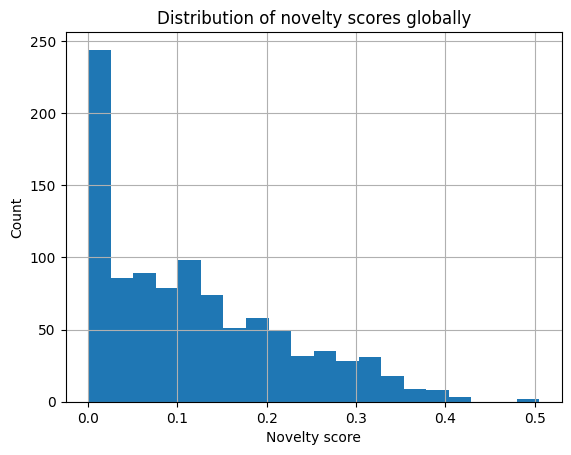

,publication_number,title,abstract,claims,ipc_classification,publication_date,assignee,legal_status,assignee_norm,assignee_group,pub_year,legal_status_clean,embed_text,embeddings,novelty_score
473,US12166374B2,Low power standby circuit,"Standby circuit for an electric appliance, the...","<div class=""indep-clm"" num=""1""><seg-con>1. A s...","H02J1/10, A47J31/52, H02J9/00",2024-12-10,SOCIETE DES PRODUITS NESTLE S.A,['Active'],SOCIETE DES PRODUITS NESTLE SA,NESTLE,2024,active,TITLE: Low power standby circuit\nABSTRACT: St...,"[-0.03483212739229202, 0.012535803020000458, -...",0.505003


In [16]:

E = np.vstack(df_NESTLE["embeddings"].dropna().to_numpy()) # (N, D) matrix
#Use the cosine similarity to determine novelty 
novelty_score = get_novelty(E)

df_NESTLE.loc[df_NESTLE["embeddings"].notna(), "novelty_score"] = novelty_score

plt.figure()
df_NESTLE["novelty_score"].hist(bins=20)   # change column name + bins as you like
plt.xlabel("Novelty score")
plt.ylabel("Count")
plt.title("Distribution of novelty scores globally")
plt.show()
df_NESTLE.loc[df_NESTLE['novelty_score'] == max(df_NESTLE["novelty_score"])]

In [17]:
import numpy as np
from sklearn.cluster import SpectralClustering

mask_valid = df_NESTLE["embeddings"].notna()
E = np.vstack(df_NESTLE.loc[mask_valid, "embeddings"].to_numpy())

spectral = SpectralClustering(
    n_clusters=3,
    affinity="nearest_neighbors",
    n_neighbors=15,
    random_state=0,
    assign_labels="kmeans",
)

cluster_ids = spectral.fit_predict(E)

df_NESTLE.loc[mask_valid, "cluster"] = cluster_ids


KMeans clustering code:
#Get clusters using embeddings

 E = np.vstack(df_NESTLE["embeddings"].dropna().to_numpy()) # (N, D) matrix kmeans = KMeans(n_clusters=3, random_state=0) cluster_ids = kmeans.fit_predict(E) df_NESTLE.loc[df_NESTLE["embeddings"].notna(), "cluster"] = cluster_ids

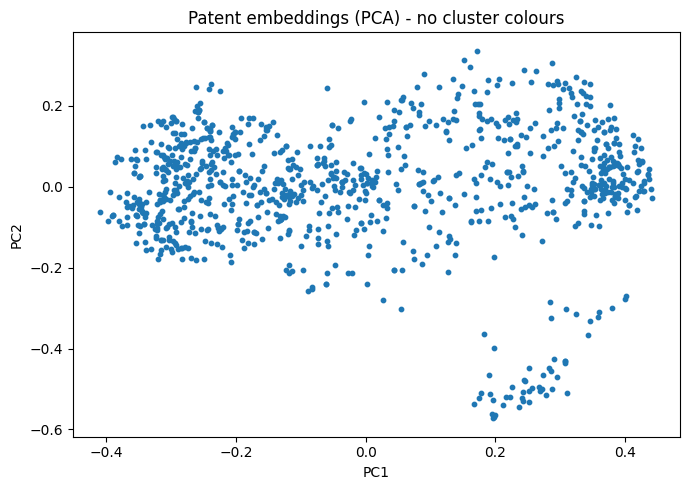

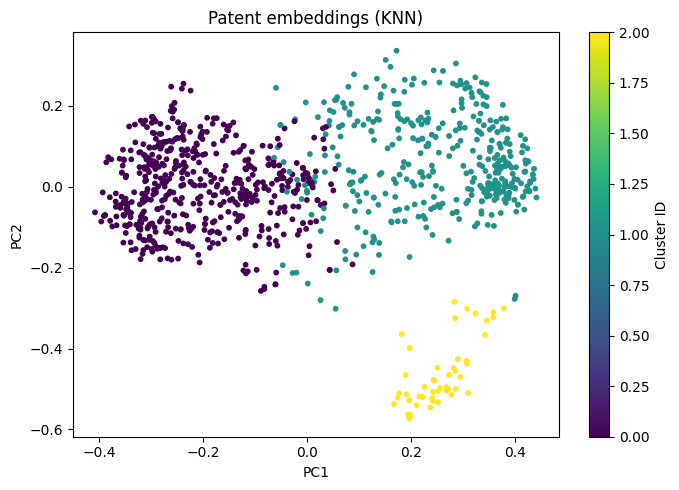

In [18]:
import numpy as np
from sklearn.decomposition import PCA

# Reduce to 2D with PCA
pca = PCA(n_components=2, random_state=0)
E_2d = pca.fit_transform(E)  # shape (N, 2)

# 1) Plain scatter plot (no cluster colouring)
plt.figure(figsize=(7, 5))
plt.scatter(
    E_2d[:, 0],
    E_2d[:, 1],
    s=10,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Patent embeddings (PCA) - no cluster colours")
plt.tight_layout()
plt.show()

# 2) Scatter plot coloured by KNN clustering
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    E_2d[:, 0],
    E_2d[:, 1],
    c=df_NESTLE["cluster"].to_numpy(),
    s=10,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Patent embeddings (KNN)")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()



Quantification of the size per cluster

In [19]:
df_NESTLE["cluster"].value_counts()

cluster
0.0    544
1.0    402
2.0     49
Name: count, dtype: int64

1 Sample representative rows per cluster

In [20]:

# How many patents per cluster to show the LLM
N_PER_CLUSTER = 10

# Get existing cluster labels (0,1,2,3)
cluster_ids = sorted(df_NESTLE["cluster"].dropna().unique())

# For each cluster, sample up to N_PER_CLUSTER rows
cluster_samples = {}
for cid in cluster_ids:
    subset = df_NESTLE.loc[df_NESTLE["cluster"] == cid]
    # sample without replacement; cap at len(subset)
    n = min(N_PER_CLUSTER, len(subset))
    sample = subset.sample(n=n, random_state=42)
    cluster_samples[cid] = sample


In [21]:
from openai import AzureOpenAI
import textwrap
# Initialize Azure OpenAI client

client = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)

def describe_cluster_theme(cluster_id, sample_df, text_col="embed_text"):
    # Build a compact text block with a few patents
    docs = []
    for i, (_, row) in enumerate(sample_df.iterrows(), start=1):
        text = str(row[text_col])
        # Optional: truncate each patent to avoid massive prompts
        text = textwrap.shorten(text, width=2000, placeholder=" ...")
        docs.append(f"PATENT {i}:\n{text}")
    
    docs_block = "\n\n-----\n\n".join(docs)

    prompt = f"""
You are analysing Nestlé patent clusters as an expert.

Below are several representative patents from CLUSTER {cluster_id}.
Each PATENT text may include title, abstract, claim snippet and IPC codes.

Your task:
1. Identify the main technical/theme area for this cluster in 1 short label.
2. Give 3–5 bullet points describing what kinds of innovations appear here
   (e.g. ingredients, target population, applications, technologies).
3. mention the main product categories (e.g. infant formula, coffee, packaging, etc.).

Respond in this JSON-like structure (no extra text):

CLUSTER_LABEL: <short label>
THEMES:
- <bullet 1>
- <bullet 2>
- <bullet 3>
- <bullet 4>
- <bullet 5>

Here are the patents:

{docs_block}
""".strip()

    resp = client.chat.completions.create(
        model="gpt-5.1",   # or your chosen model
        messages=[{"role": "user", "content": prompt}],
        max_completion_tokens=300,
    )

    return resp.choices[0].message.content.strip()


Using the sub-cluster samples to get themes overviews  from the LLM 

In [22]:
cluster_summaries = {}

for cid, sample_df in cluster_samples.items():
    summary = describe_cluster_theme(cid, sample_df, text_col="embed_text")
    cluster_summaries[cid] = summary
    print(f"\n=== CLUSTER {cid} ===")
    print(summary)



=== CLUSTER 0.0 ===
CLUSTER_LABEL: Nutrition, health biomarkers & specialty food formulations

THEMES:
- Dairy and protein processing to improve heat stability, texture, and functionality (β-lactoglobulin cross-linking)
- Design of nutritional and bioactive ingredients targeting specific health outcomes (cognitive aging, gastrointestinal barrier, necrotizing enterocolitis, pancreatic insufficiency)
- Development and use of specialized microorganisms and human milk oligosaccharides (Bifidobacterium longum strains, 2'-fucosyllactose) for gut and infant health
- Formulation technologies and processing for consumer foods (instant fried noodles, confectionery gels, RTD or reconstituted beverages, palatable dry pet food)
- Creation and optimization of enzymes and vitamin derivatives (engineered lipases, nicotinamide riboside trioleate) for improved stability, delivery, and therapeutic/nutritional effects

MAIN_PRODUCT_CATEGORIES:
- Infant and young child nutrition (including NEC prevention,

In [23]:
# mapping from numeric cluster ID → human-readable label
cluster_map = {
    0: "nutrition & food processing technologies",
    1: " beverage machines & sustainable packaging",
    2: "Coffee roasting & grinding systems and safety",
}

# add a new column with the text meaning
df_NESTLE["cluster_text"] = df_NESTLE["cluster"].map(cluster_map)


In [26]:
#collect different clusters into separate groups 

g0 = df_NESTLE.loc[df_NESTLE["cluster_text"]== cluster_map[0]]
g1 = df_NESTLE.loc[df_NESTLE["cluster_text"]== cluster_map[1]]
g2 = df_NESTLE.loc[df_NESTLE["cluster_text"]== cluster_map[2]]

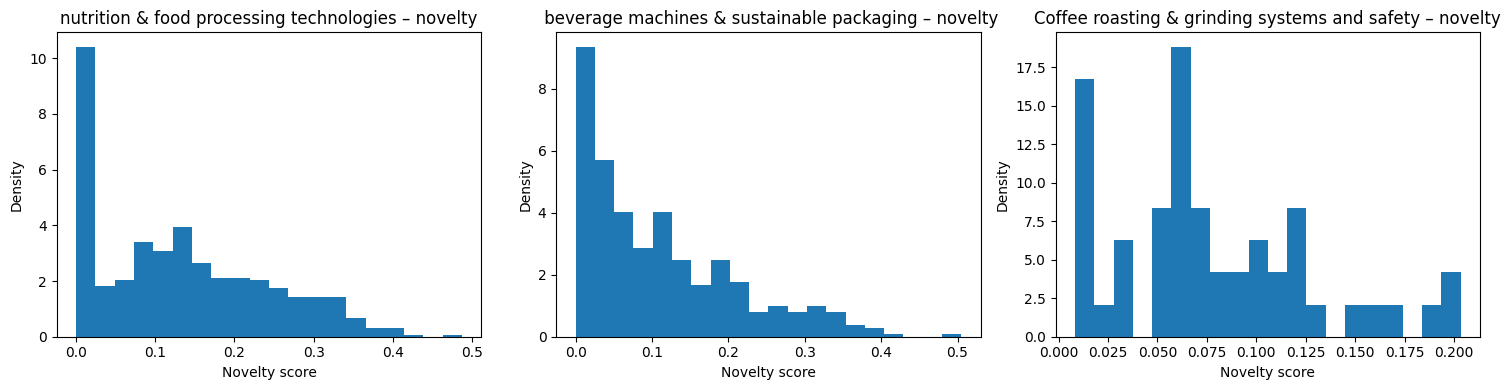

In [27]:
# Build embedding matrices for each cluster
E_0 = np.vstack(g0["embeddings"].dropna().to_numpy())
E_1 = np.vstack(g1["embeddings"].dropna().to_numpy())
E_2 = np.vstack(g2["embeddings"].dropna().to_numpy())

E_mats = [E_0, E_1, E_2]
cluster_ids = [0, 1, 2]

# One row, three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, E, cid in zip(axes, E_mats, cluster_ids):
    novelty_scores = np.asarray(get_novelty(E))

    ax.hist(novelty_scores, bins=20, density=True)
    # Use text label from cluster_map if available, else fallback
    label = cluster_map.get(cid, f"Cluster {cid}")
    ax.set_title(f"{label} – novelty")
    ax.set_xlabel("Novelty score")
    ax.set_ylabel("Density")  # since density=True

plt.tight_layout()
plt.show()


In [36]:
df_NESTLE.groupby('cluster')['novelty_score'].mean()

cluster
0.0    0.130947
1.0    0.107794
2.0    0.077457
Name: novelty_score, dtype: float64

Sample the text from each cluster + the avg novelty score per cluster then feed into LLM to see the implications and what NESTLE should do next 

Starting to look at innovation analysis over the years

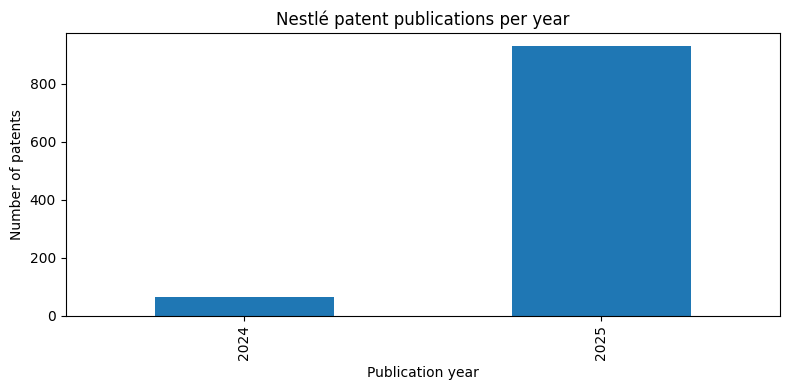

In [28]:
#Looking at the publication  per year on the dataset 
pub_counts = df_NESTLE.groupby("pub_year").size()

plt.figure(figsize=(8, 4))
pub_counts.plot(kind="bar")
plt.xlabel("Publication year")
plt.ylabel("Number of patents")
plt.title("Nestlé patent publications per year")
plt.tight_layout()
plt.show()

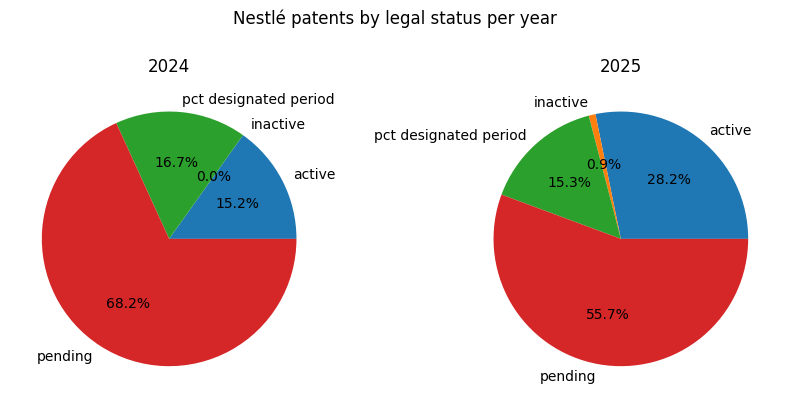

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Table: rows = years, columns = legal_status_clean
status_by_year = (
    df_NESTLE.groupby(["pub_year", "legal_status_clean"])
             .size()
             .unstack(fill_value=0)
)

years = status_by_year.index.tolist()
n_years = len(years)

# Choose a grid layout (up to 3 pies per row)
ncols = min(3, n_years)
nrows = int(np.ceil(n_years / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axes = np.array(axes).reshape(-1)  # flatten in case of 2D

for ax, (year, row) in zip(axes, status_by_year.iterrows()):
    values = row.values
    labels = row.index

    # Skip years where total is zero (just in case)
    if values.sum() == 0:
        ax.axis("off")
        continue

    ax.pie(values, labels=labels, autopct="%1.1f%%")
    ax.set_title(f"{year}")

# Turn off any unused subplots
for ax in axes[n_years:]:
    ax.axis("off")

plt.suptitle("Nestlé patents by legal status per year", y=1.02)
plt.tight_layout()
plt.show()


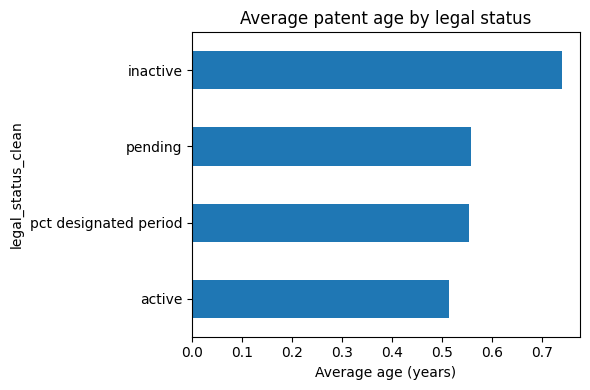

legal_status_clean
active                   0.512471
pct designated period    0.553386
pending                  0.557557
inactive                 0.738193
Name: age_years, dtype: float64


In [37]:
today = pd.Timestamp.today()
df_NESTLE["age_years"] = (today - df_NESTLE["publication_date"]).dt.days / 365.25


age_by_status = df_NESTLE.groupby("legal_status_clean")["age_years"].mean().sort_values()

plt.figure(figsize=(6, 4))
age_by_status.plot(kind="barh")
plt.xlabel("Average age (years)")
plt.title("Average patent age by legal status")
plt.tight_layout()
plt.show()

print(age_by_status)


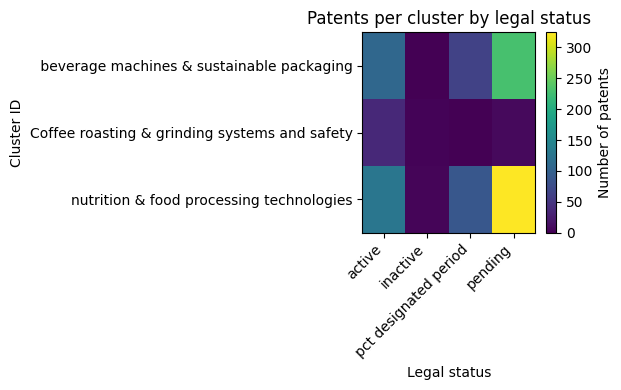

legal_status_clean                             active  inactive  \
cluster_text                                                      
 beverage machines & sustainable packaging        108         0   
Coffee roasting & grinding systems and safety      37         3   
nutrition & food processing technologies          127         5   

legal_status_clean                             pct designated period  pending  
cluster_text                                                                   
 beverage machines & sustainable packaging                        64      230  
Coffee roasting & grinding systems and safety                      1        8  
nutrition & food processing technologies                          88      324  


In [33]:
# Only run if 'cluster' exists
if "cluster" in df_NESTLE.columns:
    status_by_cluster = (
        df_NESTLE.groupby(["cluster_text", "legal_status_clean"])
          .size()
          .unstack(fill_value=0)
          .sort_index()
    )

    plt.figure(figsize=(6, 4))
    plt.imshow(status_by_cluster, aspect="auto")
    plt.xticks(
        ticks=range(len(status_by_cluster.columns)),
        labels=status_by_cluster.columns,
        rotation=45,
        ha="right",
    )
    plt.yticks(
        ticks=range(len(status_by_cluster.index)),
        labels=status_by_cluster.index,
    )
    
plt.colorbar(label="Number of patents")
plt.xlabel("Legal status")
plt.ylabel("Cluster ID")
plt.title("Patents per cluster by legal status")
plt.tight_layout()
plt.show()

print(status_by_cluster)


In [34]:
# In your Jupyter notebook
df_NESTLE.to_csv("nestle_patents.csv")
